# Homework 5 - The eternal significance of publications and citations!


---



In [44]:
# libraries
import ijson
import time
import csv
import pandas as pd
import numpy as np
import random
from decimal import Decimal
import networkx as nx
import itertools
import ast
import matplotlib.pyplot as plt
from scipy.stats import scoreatpercentile
from networkx.algorithms.community import girvan_newman
from tabulate import tabulate
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
cd  E:/University/ADM/HW5/archive

E:\University\ADM\HW5\archive



# **1. Data**
---



**Converting Json to CSV** :


In order to work with the dataset, we needed to convert the file "dblp.v12.json" from json to csv. We used the code available on kaggle [[link]](https://www.kaggle.com/code/shreyasbhatk/csv-conversion-all-fields/notebook) and modified it to fit our purposes.

In [ ]:
# run only once to get the dataset that is created in csv with the name output
'''
start = time.process_time()

count = 0

with open('dblp.v12.json', "rb") as f, open("output.csv", "w", newline="") as csvfile:
    fieldnames = ['id', 'title', 'year', 'authors', 'n_citation', 'doc_type',
                  'reference_count', 'references', 'doi','publisher']

    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, escapechar='\\')
    writer.writeheader()

    for i, element in enumerate(ijson.items(f, "item")):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        year = element.get('year')
        if year:
            paper['year'] = year
        else:
            paper['year'] = np.nan

        author = element.get('authors')
        if author:
            paper['authors']= author
        else:
            paper['authors']=np.nan

        n_citation = element.get('n_citation')
        if n_citation:
            paper['n_citation'] = n_citation
        else:
            paper['n_citation'] = np.nan

        doc_type = element.get('doc_type')
        if doc_type:
            paper['doc_type'] = doc_type
        else:
            paper['doc_type'] = np.nan

        references = element.get('references')
        if references:
            paper['reference_count'] = len(references)
            paper['references'] = ';'.join(str(int(r)) for r in references)
        else:
            paper['references'] = np.nan

        doi = element.get('doi')
        if doi:
            paper['doi'] = f"https://doi.org/{doi}"
        else:
            paper['doi'] = np.nan

        publisher= element.get('publisher')
        if publisher:
            paper['publisher']=publisher
        else:
            paper['publisher']=np.nan

        count += 1
        writer.writerow(paper)

  '''

Visualise the dataset and the columns that we have extracted from the original dataset.

In [3]:
df = pd.read_csv('output.csv')

In [4]:
df.head()

,id,title,year,authors,n_citation,doc_type,reference_count,references,doi,publisher
0,1091,Preliminary Design of a Network Protocol Learn...,2013.0,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",1.0,Conference,2.0,2005687710;2018037215,https://doi.org/10.1007/978-3-642-39476-8_19,"Springer, Berlin, Heidelberg"
1,1388,Further Results on Independence in Direct-Prod...,2000.0,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",1.0,Journal,NaN,NaN,NaN,NaN
2,1674,A methodology for the physically accurate visu...,2011.0,"[{'name': 'G. Beale', 'org': 'Archaeological C...",1.0,Conference,15.0,1535888970;1992876689;1993710814;2035653341;20...,https://doi.org/10.2312/VAST/VAST11/137-144,Eurographics Association
3,1688,"Comparison of GARCH, Neural Network and Suppor...",2009.0,"[{'name': 'Altaf Hossain', 'org': 'Department ...",6.0,Conference,3.0,1560724230;1986968751;2156909104,https://doi.org/10.1007/978-3-642-11164-8_97,"Springer, Berlin, Heidelberg"
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,2009.0,"[{'name': 'Rafael �lvarez', 'id': 2125293936},...",NaN,Conference,NaN,NaN,NaN,NaN


**Information we can get by looking at the dataset** :


The dataset provides information about a collection of papers and their citation relationships. Each paper is identified by a unique ID, the title of each paper and the publication year. The authors of each paper are organized in a dictionary format. Each paper contains the number of citations received, the type of document and the publisher. The dataset is represented by two columns representing the number of references 'Reference.count' and the column 'References', which provides a list of identifiers for the papers referenced in a given article. The DOI (Digital Object Identifier) column contains a url that identifies each article.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4894081 entries, 0 to 4894080
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int64  
 1   title            object 
 2   year             float64
 3   authors          object 
 4   n_citation       float64
 5   doc_type         object 
 6   reference_count  float64
 7   references       object 
 8   doi              object 
 9   publisher        object 
dtypes: float64(3), int64(1), object(6)
memory usage: 373.4+ MB


# Data pre-processing
---



1. Identify the top 10,000 papers with the highest number of citations

In [6]:
# First we are going to sort the dataset by the number of citations in descending order
dataset = df.sort_values(by='n_citation', ascending=False)
# We select only the first 10000 rows
dataset = dataset.nlargest(10000, 'n_citation')

In [7]:
dataset.head()

,id,title,year,authors,n_citation,doc_type,reference_count,references,doi,publisher
4696136,2041404167,The Mathematical Theory of Communication,1949.0,"[{'name': 'C. E. Shannon', 'org': 'External Or...",48327.0,Book,NaN,NaN,NaN,NaN
4630907,1639032689,"Genetic algorithms in search, optimization, an...",1989.0,"[{'name': 'David E. Goldberg', 'id': 2102678951}]",44175.0,Book,NaN,NaN,NaN,NaN
4092588,2912565176,Fuzzy sets,1996.0,"[{'name': 'Lotfi A. Zadeh', 'id': 2252586558}]",42437.0,NaN,NaN,NaN,NaN,NaN
2937610,2151103935,Distinctive Image Features from Scale-Invarian...,2004.0,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",35541.0,Journal,33.0,19720318;1541642243;1560959218;1676552347;1681...,https://doi.org/10.1023/B:VISI.0000029664.9961...,Kluwer Academic Publishers
4088311,2911964244,Random Forests,2001.0,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",34741.0,NaN,11.0,1507255258;1580948147;1605688901;1975846642;20...,https://doi.org/10.1023/A:1010933404324,NaN


# Graphs setup

1. **Citation graph**: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

In [8]:
# Create an empty directed graph
citation_graph = nx.DiGraph(name='citation graph')

In [9]:
# We are going to add our nodes which in our case is represented by each document
for index, row in dataset.iterrows():
    citation_graph.add_node(row['id'])

In [10]:
# Add edges to our graph, considering the citation relationship between these nodes
for index, row in dataset.iterrows():
    # we are going to extract the references
    reference = row['references']

    # if reference is not empty we are going to split it into a list
    if pd.notna(reference):
        references_list = reference.split(';')

        # Add edges to the graph only if the reference is present in our nodes
        for ref in references_list:
            ref_nodes = ref.strip()
            if int(ref_nodes) in citation_graph.nodes:
                citation_graph.add_edge(row['id'], int(ref_nodes))

Now that we have created our graph, we will check the number of edges and nodes and save everything in a dataset 'df_citation' so that we can better complete the next steps of our homework.

In [11]:
num_nodes = citation_graph.number_of_nodes() # check the number of nodes
print(f'Number of nodes in the citation graph: {num_nodes}')

Number of nodes in the citation graph: 10000


In [12]:
num_edges = citation_graph.number_of_edges() # check the number of edges
print(f'Number of edges in the citation graph: {num_edges}')

Number of edges in the citation graph: 52289


In [13]:
# Create a dataset that represents the citation graph with nodes and their corresponding edges
df_citation = pd.DataFrame(columns=['node', 'edges'])

for node in citation_graph.nodes:
    edges_out = list(citation_graph.successors(node))
    df_citation = pd.concat([df_citation, pd.DataFrame({'node': [node], 'edges': [edges_out]})], ignore_index=True)

# save the dataset in a csv file
df_citation.to_csv('citation_graph.csv', index=False)

In [14]:
df_citation.head()

,node,edges
0,2041404167,[]
1,1639032689,[]
2,2912565176,[]
3,2151103935,"[1676552347, 2011891945, 2024668293, 209607783..."
4,2911964244,"[1605688901, 1975846642, 2112076978, 211324281..."


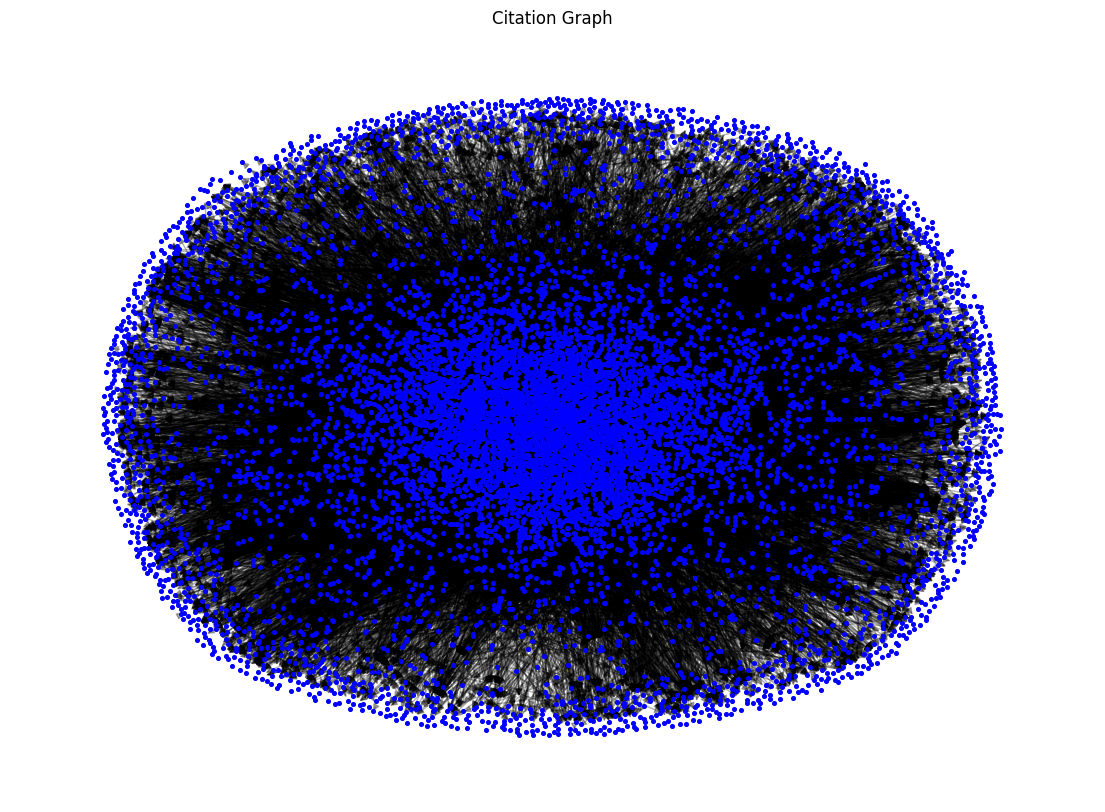

In [15]:
# Graph visualization
plt.figure(figsize=(14, 10))
# We use this layout "spring_layout" to place nodes in the chart so that the connected nodes are closer
pos = nx.spring_layout(citation_graph)
# Draw nodes
nx.draw_networkx_nodes(citation_graph, pos, node_size=7, node_color='blue')
# Draw edges
nx.draw_networkx_edges(citation_graph, pos, edge_color='black', alpha=0.3)
# Delete node labels for better visualization
plt.axis('off')
plt.title('Citation Graph')
plt.show()

Having a high number of nodes and edges, we will consider a subgraph representing the most connected component of the graph for better visualisation.

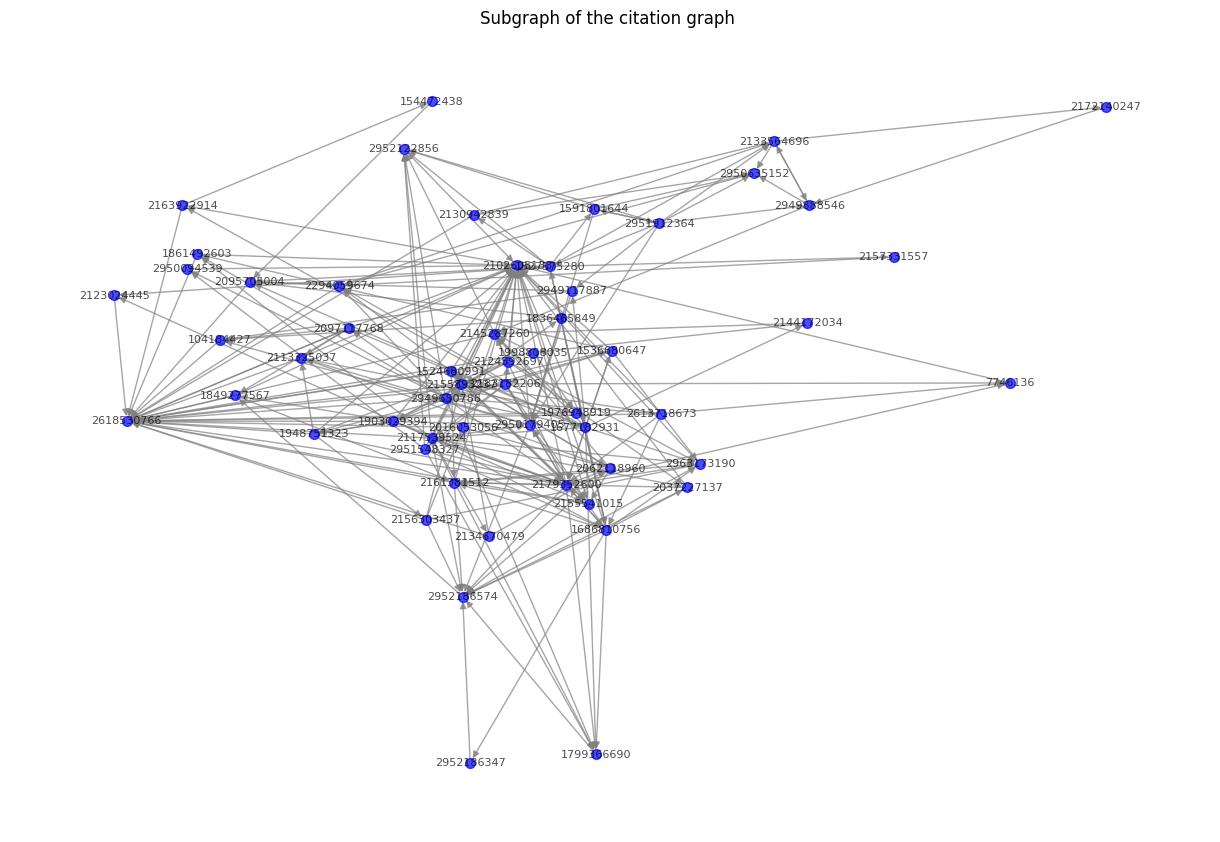

In [16]:
# Find the most connected component
largest_component = max(nx.strongly_connected_components(citation_graph), key=len)

# Create a subgraph
subgraph = citation_graph.subgraph(largest_component)

# Visualize the subgraph
pos = nx.spring_layout(subgraph, seed=123)
plt.figure(figsize=(12, 8))
nx.draw(subgraph, pos, with_labels=True, node_size=50, font_size=8, font_color='black', node_color='blue', edge_color='gray', alpha=0.7)

# Show the plot
plt.title('Subgraph of the citation graph ')
plt.show()

**Collaboration graph**: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted

In [17]:
# function that adds nodes to the graph for each author
def nodes(graph, author_names):
    for author_name in author_names:
        graph.add_node(author_name)

In [18]:
# function that creates weighted edges
# We decided to add weighted edges based on the number of shared paper that two authors had together
def weighted_edges(graph, author_names):
    for i, first_author in enumerate(author_names):
        for j, second_author in enumerate(author_names):
            if i < j:
                shared_papers = len(set(first_author) & set(second_author))
                graph.add_edge(first_author, second_author, weight=shared_papers)

In [19]:
# create an empty undirected graph
collaboration_graph = nx.Graph()

In [20]:
# Select the name for each author that is going to represent our nodes
for index, row in dataset.iterrows():
    authors = ast.literal_eval(row['authors'])
    author_names = [author['name'] for author in authors]

    # Add nodes to the graph
    nodes(collaboration_graph, author_names)

    # Add weighted edges based on shared papers
    weighted_edges(collaboration_graph, author_names)

As before, we will check the number of edges and nodes and save everything in a dataset 'df_collaboration'.

In [21]:
n_nodes = collaboration_graph.number_of_nodes() # check the number of nodes
print(f'Number of nodes in the collaboration graph: {n_nodes}')

Number of nodes in the collaboration graph: 23154


In [22]:
n_edges = collaboration_graph.number_of_edges() # check the number of edges
print(f'Number of edges in the collaboration graph: {n_edges}')

Number of edges in the collaboration graph: 139134


In [23]:
# Create a dataset representing the collaboration graph
# It represents two authors 'author1' and 'author2' who are involved in the same collaboration (edge)
# the third columm is the 'weight' which represents the number of shared papers between the authors
df_collaboration = pd.DataFrame(collaboration_graph.edges(data=True), columns=['author1', 'author2', 'weight'])
# save the dataset in a csv file
df_collaboration.to_csv('collaboration_graph.csv', index=False)

In [24]:
df_collaboration.head()

,author1,author2,weight
0,David E. Goldberg,Kalyanmoy Deb,{'weight': 7}
1,David E. Goldberg,Jon Richardson,{'weight': 6}
2,David E. Goldberg,John H. Holland,{'weight': 6}
3,David E. Goldberg,Bradley Korb,{'weight': 8}
4,Lotfi A. Zadeh,Hubert L. Dreyfus,{'weight': 6}


We create a subgraph that will represent the most connected component of the collaboration graph.

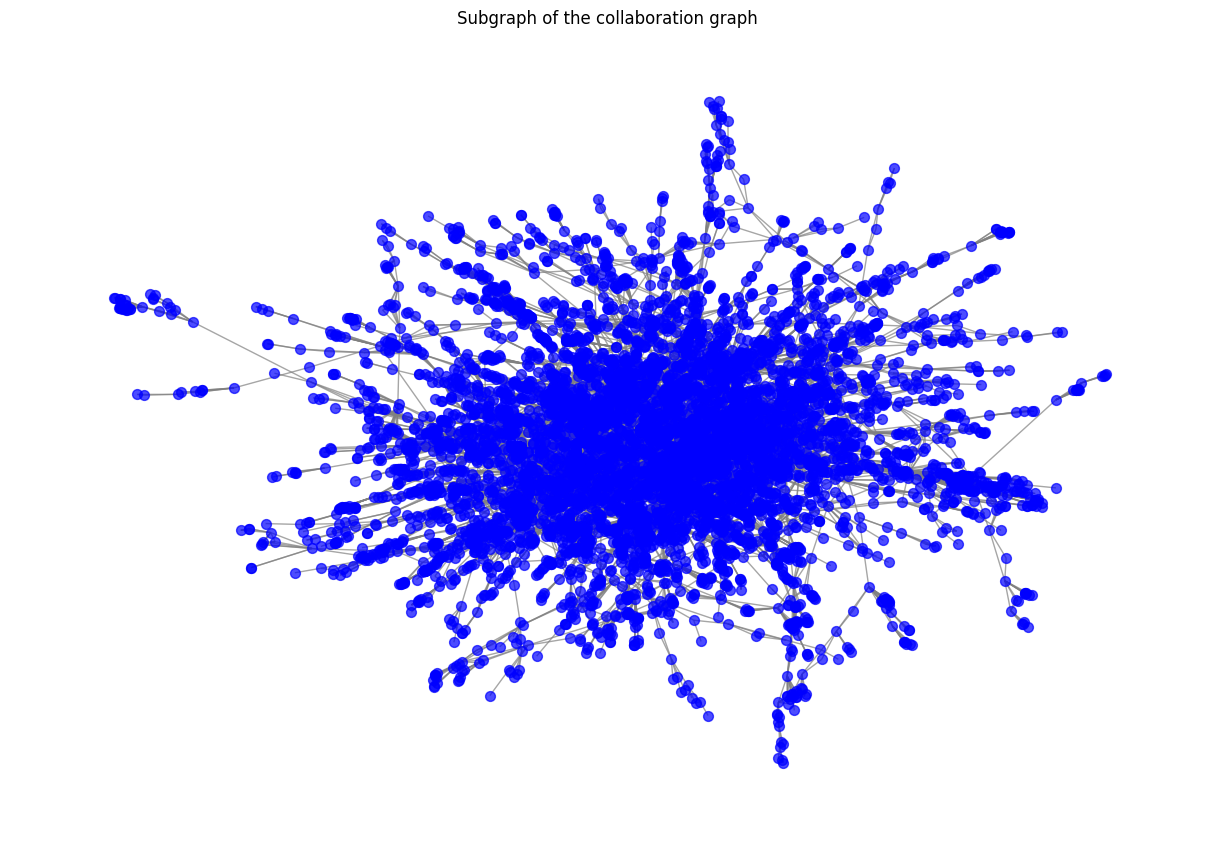

In [231]:
# Find the largest connected component
largest_component = max(list(nx.connected_components(collaboration_graph)), key=len)

# Create a subgraph
collaboration_subgraph = collaboration_graph.subgraph(largest_component)

# Visualize the subgraph
pos = nx.spring_layout(collaboration_subgraph, seed=123)
plt.figure(figsize=(12, 8))
nx.draw(collaboration_subgraph, pos, with_labels=False, node_size=50, font_size=8, font_color='black', node_color='blue', edge_color='gray', alpha=0.7)

# Show the plot
plt.title('Subgraph of the collaboration graph ')
plt.show()

<H1>2 Controlling system</H1>

## 2.1 Backend Implementation

#### Functionality 1 - Graph's features
Here, we use the NetworkX library to find the number of nodes, the number of edges, The density of the graph, the degree sequence, the average degree, The hubs of the graph (Degree above 95%) and weather the graph is dense or sparse.

In [26]:
def analyze_graph(graph, graph_name):
    # Number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()

    # Graph density
    density = nx.density(graph)

    # Degree distribution
    degree_sequence = list(dict(graph.degree()).values())

    # Average degree
    average_degree = np.mean(degree_sequence)

    # Hubs (nodes with degrees greater than the 95th percentile)
    percentile_95 = scoreatpercentile(degree_sequence, 95)
    hubs = [node for node, degree in graph.degree() if degree > percentile_95]

    # Whether the graph is dense or sparse
    density_label = "dense" if density >= 0.5 else "sparse"

    # Output report
    report = f"Analysis report for graph '{graph_name}':\n"
    report += f"Number of nodes: {num_nodes}\n"
    report += f"Number of edges: {num_edges}\n"
    report += f"Graph density: {density}\n"
    report += f"Graph degree distribution: {degree_sequence}\n"
    report += f"Average degree: {average_degree}\n"
    report += f"Graph hubs: {hubs}\n"
    report += f"The graph is {density_label}.\n"

    return report

In [27]:
result_report = analyze_graph(collaboration_subgraph, "collaboration_subgraph")
print(result_report)

Analysis report for graph 'collaboration_subgraph':
Number of nodes: 8052
Number of edges: 102813
Graph density: 0.0031719361351562627
Graph degree distribution: [34, 111, 21, 2, 1, 7, 29, 5, 2, 5, 2, 6, 6, 1, 14, 2, 5, 11, 5, 8, 133, 17, 10, 3, 9, 3, 4, 7, 2, 75, 10, 2, 18, 13, 8, 91, 8, 31, 6, 1, 2, 6, 4, 20, 6, 3, 1, 12, 11, 7, 30, 1, 3, 5, 6, 1, 5, 42, 7, 4, 3, 260, 5, 119, 6, 6, 9, 8, 18, 29, 3, 20, 7, 3, 3, 260, 4, 2, 133, 3, 4, 1, 3, 4, 4, 2, 2, 1, 5, 3, 31, 4, 15, 3, 7, 8, 1, 25, 5, 2, 260, 8, 4, 4, 7, 4, 6, 1, 9, 11, 4, 23, 9, 4, 3, 3, 188, 5, 3, 4, 19, 17, 4, 4, 4, 4, 13, 6, 1, 27, 2, 24, 4, 3, 7, 9, 47, 1, 2, 2, 2, 5, 5, 10, 1, 3, 133, 5, 2, 31, 7, 46, 5, 20, 67, 113, 260, 1, 6, 5, 8, 3, 14, 2, 3, 1, 9, 28, 2, 4, 30, 41, 20, 32, 7, 23, 3, 4, 1, 13, 260, 2, 13, 4, 6, 5, 2, 3, 12, 16, 12, 2, 1, 1, 55, 4, 6, 5, 284, 1, 75, 1, 4, 2, 8, 4, 11, 3, 2, 6, 15, 6, 2, 260, 1, 12, 8, 4, 19, 3, 15, 105, 6, 18, 3, 26, 8, 5, 8, 18, 5, 40, 6, 5, 2, 4, 3, 6, 2, 29, 46, 18, 41, 1, 2, 5, 11, 1

#### Functionality 2 - Nodes Contribution
Here, Using the NetworkX library again to find the Centrality measurement, betweenness centrality, pagerank centrality, closeness centrality and dgree centrality for a node. (We are using author and the collaboration_subgraph here)

In [28]:
def calculate_centrality(graph, node):
    # Calculate centrality measurements
    betweenness_centrality = nx.betweenness_centrality(graph)[node]
    pagerank_centrality = nx.pagerank(graph)[node]
    closeness_centrality = nx.closeness_centrality(graph)[node]
    degree_centrality = nx.degree_centrality(graph)[node]

    # Output report
    report = f"Centrality measurements for {node} in the graph '{collaboration_graph}':\n"
    report += f"Betweenness Centrality: {betweenness_centrality}\n"
    report += f"PageRank Centrality: {pagerank_centrality}\n"
    report += f"Closeness Centrality: {closeness_centrality}\n"
    report += f"Degree Centrality: {degree_centrality}\n"

    return report

In [29]:
centrality_report = calculate_centrality(collaboration_subgraph, 'A MacDougall')
print(centrality_report)

Centrality measurements for A MacDougall in the graph 'Graph with 23154 nodes and 139134 edges':
Betweenness Centrality: 1.6826130580844787e-08
PageRank Centrality: 0.00012135904728799684
Closeness Centrality: 0.07647662290784049
Degree Centrality: 0.017264936032790956



#### Functionality 3 - Shortest ordered walk
The point of this function is to find the shortest walk from first node(author) to the last. We will be using the Collaboration_graph for this one.

In [357]:
def find_connected_authors(graph, author):
    # Check if the author is in the graph
    if author not in graph:
        return f"The author '{author}' is not in the graph."

    # Find the connected component containing the specified author
    connected_component = nx.node_connected_component(graph, author)

    # Convert the connected component to a list
    connected_authors = list(connected_component)

    return connected_authors

def shortest_collaboration_walk(graph, authors, start_author, end_author, df):
    # Check if start and end authors are in the graph
    if start_author not in graph or end_author not in graph:
        return "There is no such path."

    # Initialize the path and papers_along_path variables
    shortest_path = []
    
    # Iterate through connected components
    for author in authors:
        connected_authors = find_connected_authors(graph, author)

        # Check if start and end authors are part of the connected component
        if start_author in connected_authors and end_author in connected_authors:
            # Create a subgraph with only the relevant authors from the connected component
            subgraph = graph.subgraph(connected_authors)

            # Find the shortest path from start_author to end_author
            try:
                shortest_path = nx.shortest_path(subgraph, source=start_author, target=end_author)
            except nx.NetworkXNoPath:
                continue  # Try the next connected component
            break  # Exit the loop once a valid path is found

    if not shortest_path:
        return "There is no such path."

    return shortest_path

In [358]:
authors_a = ['A MacDougall', 'Chieko Kai']
start_author = authors_a[0]
end_author = authors_a[-1] 

result = shortest_collaboration_walk(collaboration_subgraph, authors_a, start_author, end_author, dataset)
print(result)

['A MacDougall', 'H Huang', 'Wei Yu', 'J.M. Cioffi', 'D.P. Palomar', 'Mung Chiang', 'Jennifer Rexford', 'Tom Anderson', 'Timothy Roscoe', 'Paul Barham', 'Ian J. Goodfellow', 'David Warde-Farley', 'Gary D. Bader', 'Chris Sander', 'Liisa Holm', 'Robert D. Finn', 'Timo Lassmann', 'Chieko Kai']


Now that we have the Nodes for the shortest pathway, we find the common papers of our authors to find the papers we need to go through.

In [359]:
# Function to get papers by a list of author names
def get_papers_by_authors(author_names, dataframe):
    author_papers = []
    for index, row in dataframe.iterrows():
        authors_str = row['authors']
        authors_list = authors_str.split(';')  
        for author_name in authors_list:
            if any(name in author_name for name in author_names):
                author_papers.append({'title': row['title'], 'year': row['year'], 'authors': author_name, 'id': row['id']})
                break  # Break out of the inner loop once a match is found
    return author_papers

In [360]:
# Function to get papers along the shortest path
def get_papers_along_shortest_path(authors_path, dataframe):
    papers_along_path = []
    for i in range(len(authors_path) - 1):
        start_author = authors_path[i]
        end_author = authors_path[i + 1]
        # Get the shortest path papers between the current pair of authors
        path_papers = get_papers_by_authors([start_author, end_author], dataframe)
        papers_along_path.extend(path_papers)
    return papers_along_path

In [361]:
# Get papers along the shortest path
papers_along_shortest_path = get_papers_along_shortest_path(result, dataset)

# Display the result
print(f"Length of the shortest walk is {len(papers_along_shortest_path)}")
for paper in papers_along_shortest_path:
    print(f"Title: {paper['title']}")

Length of the shortest walk is 128
Title: UniProt: A hub for protein information
Title: Activities at the Universal Protein Resource (UniProt)
Title: Multi-Cell MIMO Cooperative Networks: A New Look at Interference
Title: The Universal Protein Resource (UniProt) in 2010
Title: UniProt: A hub for protein information
Title: Activities at the Universal Protein Resource (UniProt)
Title: Multi-Cell MIMO Cooperative Networks: A New Look at Interference
Title: Dual methods for nonconvex spectrum optimization of multicarrier systems
Title: Iterative water-filling for Gaussian vector multiple-access channels
Title: The Universal Protein Resource (UniProt) in 2010
Title: Distributed multiuser power control for digital subscriber lines
Title: Sum capacity of Gaussian vector broadcast channels
Title: Transmitter Optimization for the Multi-Antenna Downlink With Per-Antenna Power Constraints
Title: Multi-Cell MIMO Cooperative Networks: A New Look at Interference
Title: Spatio-temporal coding for wir

#### ChatGPT Version
Unfortunately the ChatGPT version doesn't produce output.

In [35]:
def shortest_collaboration_walk(graph, start_author, end_author, dataframe):
    if start_author not in graph or end_author not in graph:
        return "There is no such path."

    # Extract the subgraph containing only the relevant authors
    subgraph = graph.subgraph([start_author, end_author])

    try:
        # Find the shortest path using NetworkX
        shortest_path = nx.shortest_path(subgraph, source=start_author, target=end_author)
    except nx.NetworkXNoPath:
        return "There is no such path."

    # Filter the dataframe for papers along the shortest path
    papers_along_path = dataframe[
        dataframe['authors'].apply(lambda x: any(author in x for author in shortest_path))
    ][['title', 'year', 'authors']]

    return papers_along_path

In [ ]:
authors_a = ['A MacDougall', 'Chieko Kai']
start_author = authors_a[0]
end_author = authors_a[-1]

path_length, papers_along_shortest_path = shortest_collaboration_walk(
    collaboration_subgraph, start_author, end_author, dataset
)

print(f"Length of the shortest walk is {path_length}")
print(papers_along_shortest_path)

#### Functionality 4 - Disconnecting Graphs
Here, the function calculates the edge connectivity between two nodes in a graph, representing the minimum number of edges that need to be removed to disconnect them.

In [132]:
def min_edges_to_disconnect(graph, authorA, authorB):
    try:
        # Compute the edge connectivity between authorA and authorB
        min_cut_value = nx.minimum_edge_cut(graph, s=authorA, t=authorB)

        # Number of edges in the minimum edge cut
        min_cut_size = len(min_cut_value)

        return min_cut_size
    except nx.NetworkXError as e:
        # Handle the case when the graph is not connected
        print(f"Error: {e}")
        return None

In [133]:
# Example authors (nodes in the graph)
authorA = "Jeffrey Dean"
authorB = "Paul Christiano"

# Calculate the minimum number of edges to disconnect the graph
min_edges = min_edges_to_disconnect(collaboration_graph, authorA, authorB)

if min_edges is not None:
    print(f"The minimum number of edges to disconnect the graph is: {min_edges}")

The minimum number of edges to disconnect the graph is: 111


#### Functionality 5 - Extracting Communities
To figure out how many communities we should divide our papers into, we use the elbow method to find optimum number of communities. 

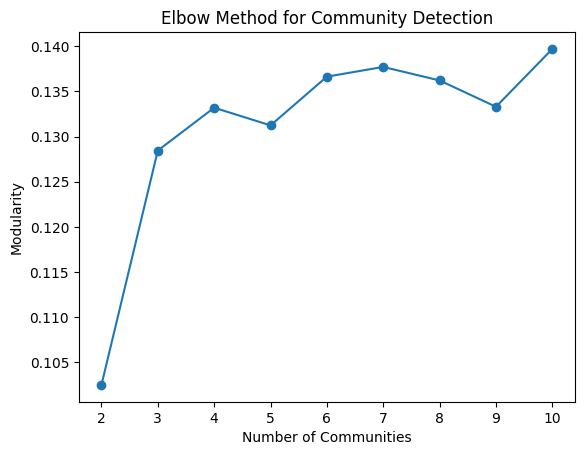

In [38]:
from networkx.algorithms.community import quality

# Assuming you have a graph 'subgraph' defined

num_communities_range = range(2, 11)
modularity_values = []

for num_communities in num_communities_range:
    communities_generator = girvan_newman(subgraph)
    for _ in range(num_communities - 1):
        communities = next(communities_generator)
    
    # Select the final partition
    partition = tuple(sorted(c) for c in next(communities_generator))
    
    # Calculate modularity for the current community structure
    modularity = quality.modularity(subgraph, partition)
    modularity_values.append(modularity)

# Plot the results
plt.plot(num_communities_range, modularity_values, marker='o')
plt.title('Elbow Method for Community Detection')
plt.xlabel('Number of Communities')
plt.ylabel('Modularity')
plt.show()

From the graph we can see that 4 would be our optimum number of communities. Now using Gervan-Newman algorithm we divide our graph into communities. We can calculate the minimum number of edges that should be removed to form communities, list of communities, each containing a list of papers that belong to them & findout whether the Paper_1 and Paper_2 belongs to the same community.

In [39]:
# Apply the Girvan-Newman algorithm for community detection
communities_generator = girvan_newman(subgraph)

# Set the desired number of communities (replace 3 with your desired number)
num_communities = 4

# Get the communities after removing edges until the desired number is reached
for _ in range(num_communities - 1):
    communities = next(communities_generator)

# Get the minimum number of edges to be removed
min_edges_to_remove = len(subgraph.edges) - len(communities)

# Identify communities
communities_dict = {}
for i, community_set in enumerate(communities):
    for paper in community_set:
        communities_dict[paper] = i

Paper_1 = 2172140247
Paper_2 = 1976948919

community_paper_1 = communities_dict.get(Paper_1)
community_paper_2 = communities_dict.get(Paper_2)
same_community = community_paper_1 == community_paper_2

# Output results
print(f"Minimum number of edges to remove: {min_edges_to_remove}")
print("Communities:")
for i, community_set in enumerate(communities):
    print(f"Community {i}: {community_set}")
print(f"{Paper_1} belongs to Community {community_paper_1}")
print(f"{Paper_2} belongs to Community {community_paper_2}")
print(f"{Paper_1} and {Paper_2} belong to the same community: {same_community}")

Minimum number of edges to remove: 234
Communities:
Community 0: {2037227137, 2144172034, 1686810756, 2161381512, 2134670479, 2613718673, 1903029394, 2155541015, 2179352600, 2294059674, 1524680991, 1799366690, 2951548327, 2095705004, 2062118960, 1976948919, 2124592697, 1836465849, 2949117887, 2016053056, 2117539524, 2963173190, 1536680647, 2097117768, 2950094539, 2102605133, 2952186574, 2950179405, 2618530766, 2156303437, 1677182931, 7746136, 1948751323, 2145287260, 2163922914, 2949650786, 1998808035, 2952122856, 2952186347, 104184427, 2113325037, 2155893237, 1861492603, 2183182206, 1849277567}
Community 1: {2949888546, 2172140247, 2951912364, 1591801644, 2950635152, 2130942839, 2133564696}
Community 2: {1527575280, 2157331557, 2123024445}
Community 3: {154472438}
2172140247 belongs to Community 1
1976948919 belongs to Community 0
2172140247 and 1976948919 belong to the same community: False


<H2>2.2 Frontend Implementation</H2>

<H3>Visualization 1 - Visualize graph features</H3>

For this feature are shown:

* A table containing the following general information about the graph:
    * Number of nodes in the graph
    * Number of the edges in the graph
    * Density of the Graph
    * Average degree of the graph
    * whether the network is sparse or dense
* A table that lists the graph's hubs
* A plot depicting the distribution of the citations received by papers (Citation graph only)
* A plot depicting the distribution of the given citations by pepers (Citation graph only)
* A plot depicting the number of collaborations of the author (Collaboration graph only)

In [305]:
def analyze_graph_2(graph, graph_name):
    # Number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()

    # Graph density
    density = nx.density(graph)

    # Degree distribution
    degree_sequence = list(dict(graph.degree()).values())

    # Average degree
    average_degree = np.mean(degree_sequence)

    # Hubs (nodes with degrees greater than the 95th percentile)
    percentile_95 = scoreatpercentile(degree_sequence, 95)
    hubs = [node for node, degree in graph.degree() if degree > percentile_95]

    # Whether the graph is dense or sparse
    density_label = "dense" if density >= 0.5 else "sparse"

    return graph_name, num_nodes, num_edges, density, degree_sequence, average_degree, hubs, density_label

# This function uses tabulate library to create a formatted table and print it
def print_analysis_table(data):
    # Define headers for the analysis table
    headers = ["Number of nodes in the graph", "Number of the edges in the graph", "Density of the graph", "Average degree of the graph", "Whether the network is sparse or dense"]
    # Use 'tabulate' to create a formatted table and print it
    table = tabulate([data], headers, tablefmt="grid", numalign="center", stralign="center")
    print(table)

# The function uses the 'tabulate' library to create a formatted table with enumerated hub indices and their corresponding values and print it
def print_hub_table(hub_list):
    # Use 'tabulate' to create a formatted table with enumerated hub values and print it
    table = tabulate(enumerate(hub_list), headers=["Hub Index", "Hub Value"], tablefmt="grid")
    print(table)

In [323]:
# Analyze the collaboration graph using the analyze_graph_2 function with graph name as input
def feature_1(graph_name):
    if graph_name == 'collaboration_graph':
        graph_name, num_nodes, num_edges, density, degree_sequence, average_degree, hubs, density_label = analyze_graph_2(collaboration_graph, "collaboration_graph")
    elif graph_name == 'citation_graph':
        graph_name, num_nodes, num_edges, density, degree_sequence, average_degree, hubs, density_label = analyze_graph_2(citation_graph, "citation_graph")

    # Count the occurrences of each degree in the degree sequence
    degree_counts = Counter(degree_sequence)
    # Extract unique degrees and their corresponding counts
    degrees = list(degree_counts.keys())
    counts = list(degree_counts.values())
    
    # Print the info table
    print("Print the info table of the", graph_name)
    print_analysis_table([num_nodes, num_edges, density, average_degree, density_label])
    print("\n")
    
    # Print the hub table
    print_hub_table(hubs[:10])
    print("\n")

    if graph_name == 'collaboration_graph':
        # Plotting the distribution
        plt.figure(figsize=(12, 6))
        plt.bar(degrees, counts, color='skyblue')
        plt.xlabel('Degree')
        plt.ylabel('Number of Nodes')
        plt.title('Collaboration graph - Degree Distribution')
        plt.show()

<H3>Visualization 2 - Visualize the node's contribution</H3>

For this feature is shown:
* A table containing the node's centrality values, based on the four centrality measure

In [309]:
def calculate_centrality_2(graph, node):
    # Calculate centrality measurements
    betweenness_centrality = nx.betweenness_centrality(graph)[node]
    pagerank_centrality = nx.pagerank(graph)[node]
    closeness_centrality = nx.closeness_centrality(graph)[node]
    degree_centrality = nx.degree_centrality(graph)[node]
    
    return node, collaboration_graph, betweenness_centrality, pagerank_centrality, closeness_centrality, degree_centrality

# This function uses tabulate library to create a formatted table and print it
def print_centrality_table(data):
    # Define headers for the analysis table
    headers = ["Node name", "Graph name", "Betweenness Centrality", "PageRank Centrality", "Closeness Centrality", "Degree Centrality"]
    # Use 'tabulate' to create a formatted table and print it
    table = tabulate([data], headers, tablefmt="grid", numalign="center", stralign="center")
    print(table)

# Analyze the collaboration graph using the calculate_centrality_2 function with graph name and node name as input
def feature_2(graph, graph_name, node_name):
    
    if graph_name == 'collaboration_graph':
        node, collaboration_graph, betweenness_centrality, pagerank_centrality, closeness_centrality, degree_centrality = calculate_centrality_2(graph, node_name)
    
    elif graph_name == 'citation_graph':
        node, citation_graph, betweenness_centrality, pagerank_centrality, closeness_centrality, degree_centrality = calculate_centrality_2(graph, node_name)
    
    print_centrality_table([node, collaboration_graph, betweenness_centrality, pagerank_centrality, closeness_centrality, degree_centrality])

<H3>Visualization 3 - Visualize the shortest-ordered route</H3>

For this feature are shown:
* The paper needed to be crossed in the shortest walk in order
* The plot of the graph identifying the nodes and edges that appear in the shortest walk

In [364]:
# This function uses tabulate library to create a formatted table and print it
def print_route_table(data):
    # Define headers for the analysis table
    headers = ["Step", "Paper name"]
    # Use 'tabulate' to create a formatted table and print it
    table = tabulate(data, headers, tablefmt="grid", numalign="center", stralign="center")
    print(table)

def feature_3(authors_a, collaboration_subgraph, dataset):
    # Get papers along the shortest path
    start_author = authors_a[0]
    end_author = authors_a[-1]
    result = shortest_collaboration_walk(collaboration_subgraph, authors_a, start_author, end_author, dataset)
    papers_along_shortest_path = get_papers_along_shortest_path(result, dataset)

    # Get two ordered papers list, one with enumerated values
    ordered_paper_list_n = []
    ordered_paper_list = []
    i = 0
    for paper in papers_along_shortest_path:
        ordered_paper_list.append(paper['id'])
        ordered_paper_list_n.append([i, paper['title']])
        i += 1

    print_route_table(ordered_paper_list_n)
    print("\n")

    # Identify nodes and edges in the shortest walk
    shortest_walk_nodes = set(ordered_paper_list)
    shortest_walk_edges = [(ordered_paper_list[i], ordered_paper_list[i + 1]) for i in range(len(ordered_paper_list) - 1)]
    
    # Plot the graph
    pos = nx.spring_layout(citation_graph)
    nx.draw(citation_graph, pos, with_labels=True, node_size=50, font_size=1, font_color='black', edge_color='gray', linewidths=0.5, alpha=0.7)
    
    # Highlight nodes and edges in the shortest walk
    nx.draw_networkx_nodes(collaboration_subgraph, pos, nodelist=shortest_walk_nodes, node_color='red', node_size=100)
    nx.draw_networkx_edges(collaboration_subgraph, pos, edgelist=shortest_walk_edges, edge_color='red', width=2)
    
    plt.show()

<H3>Visualization 4 - Visualize the disconnected graph</H3>

For this feature are shown:
* The number of the links that should be disconnected
* The plot of the original graph
* The plot of the graph after removing the links and identifying the two ndoes

In [236]:
def min_edges_to_disconnect_2(graph, authorA, authorB):
    try:
        # Compute the edge connectivity between authorA and authorB
        min_cut_value = nx.minimum_edge_cut(graph, s=authorA, t=authorB)

        # Number of edges in the minimum edge cut
        min_cut_size = len(min_cut_value)

        return min_cut_value, min_cut_size
    except nx.NetworkXError as e:
        # Handle the case when the graph is not connected
        print(f"Error: {e}")
        return None

def feature_4(subgraph, authorA, authorB):
    # Calculate the minimum number of edges to disconnect the graph
    cut_edges, min_edges = min_edges_to_disconnect_2(subgraph, authorA, authorB)
    if min_edges is not None:
        print(f"The minimum number of edges to disconnect the graph is: {min_edges}")
        print(cut_edges)
        print('\n')
    
    # Visualize the disconnected subgraph
    pos = nx.spring_layout(subgraph, seed=123)
    plt.figure(figsize=(10, 6))
    nx.draw(subgraph, pos, with_labels=True, node_size=50, font_size=8, font_color='black', node_color='blue', edge_color='gray', alpha=0.7)
    # Show the plot
    plt.title('SubGraph ')
    plt.show()
    
    # Visualize the subgraph
    graph_cut = subgraph.copy()
    graph_cut.remove_edges_from(cut_edges)
    # Find the connected components (disconnected subgraphs) in the modified graph
    disconnected_subgraphs = list(nx.weakly_connected_components(graph_cut))
    for i, subgraph_nodes in enumerate(disconnected_subgraphs):
        print('\n')
        subgraph_ = subgraph.subgraph(subgraph_nodes)
        pos_subgraph = nx.spring_layout(subgraph_)
        nx.draw(subgraph_, pos_subgraph, with_labels=True, node_size=50, font_size=8, font_color='black', node_color='blue', edge_color='gray', alpha=0.7)
        plt.title(f"Disconnected Subgraph {i + 1}")
        plt.show()

<H3>Visualization 5 - Visualize the communities</H3>

For this feature are shown:
* The number of links that should be removed to have the communities
* A table depicting the communities and the papers that belogn o each community
* The plot of the original graph
* The plot of the graph showing the communities in the network
* The plot of the final graph identifying the communities of Paper 1 and Paper 2

In [311]:
def feature_5(min_edges_to_remove, communities, subgraph):
    # Output results
    print(f"Minimum number of edges to remove: {min_edges_to_remove}\n")
    
    table = []
    for i, community_set in enumerate(communities):
        table.append([f"Insieme {i}", ', '.join(map(str, community_set))])
    headers = ["Set number", "Elements"]
    print(tabulate(table, headers, tablefmt="grid", maxcolwidths=[None, 100]))
    print('\n')
    
    # Visualize the subgraph
    pos = nx.spring_layout(subgraph, seed=123)
    plt.figure(figsize=(10, 6))
    nx.draw(subgraph, pos, with_labels=True, node_size=50, font_size=8, font_color='black', node_color='blue', edge_color='gray', alpha=0.7)
    plt.title('Original Graph ')
    plt.show()
    print('\n')
    
    # Create a color map for nodes based on communities
    colors = []
    for node in subgraph.nodes():
        for i, community in enumerate(communities):
            if node in community:
                colors.append(i)
                break
    
    # Plot the graph
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, node_color=colors, cmap=plt.cm.Set1, node_size=700, font_size=10, font_color='black', edge_color='gray', linewidths=1, alpha=0.7)
    plt.title('Communities Graph')
    plt.show()
    print('\n')
    
    
    # Create a color map for nodes based on community membership
    node_colors = []
    for node in subgraph.nodes():
        for i, community in enumerate(communities):
            if node in community and i == community_paper_1:
                node_colors.append('red')
                break
            elif node in community and i == community_paper_2:
                node_colors.append('blue')
                break
            elif node in community:
                node_colors.append('gray')
                break
    # Plot the graph
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=700, font_size=10, font_color='black', edge_color='gray', linewidths=1, alpha=0.7)
    plt.title('Two communities Graph')
    plt.show()

<H3>User's interface</H3>

In this cell is the code that allows the user to select a certain feature with any additional parameters to be entered for a quick and clear display.


An infinite while loop allows for the repetition of queries by the user, who first has to select the feature they want displayed on the screen.


After selecting the feature according to the various cases, further parameters are requested or guaranteed to be correct, otherwise exceptions will be displayed.


Finally, according to the realisation of the visualisation of the various features, different results are shown.

In [343]:
def feature_input(collaboration_subgraph, citation_graph, subgraph, min_edges_to_remove, communities, dataset):
    while True:
        
        # Get user input for selecting a feature
        feature = input("Please insert a number from 1 to 5 to select a feature, 0 to esc")

        # Exit the function if the user chooses 0
        if feature == '0':
            return
        
        elif feature == '1':
            print("You chose feature 1")
            # Get user input for selecting a graph
            graph_name = input("Please insert the graph name to analize: 'collaboration graph' or 'citation graph', 0 to esc")
            while True:
                # Exit the function if the user chooses 0
                if graph_name == '0':
                    break
                elif graph_name == 'collaboration graph':
                    feature_1('collaboration_graph')
                elif graph_name == 'citation graph':
                    feature_1('citation_graph')
                else:
                    # Handle invalid input for graph name
                    graph_name = input("Invalid option. Please insert the graph name to analize: 'collaboration graph' or 'citation graph', 0 to esc")
                    continue
                break
            continue
        
        elif feature == '2':
            print("You chose feature 2")
            # Get user input for selecting a graph
            graph_name = input("Please insert the graph name to analize: 'collaboration Graph' or 'citation Graph', 0 to esc")
            # Get user input for selecting a node
            node_name = input("Please insert a node name to analize")
            while True:
                # Exit the function if the user chooses 0
                if graph_name == '0':
                    break
                elif graph_name == 'collaboration graph':
                    # Handle invalid input for node name
                    if node_name in collaboration_graph.nodes:
                        feature_2(collaboration_subgraph, 'collaboration_graph', node_name)
                    else:
                        print('node not present in the graph')
                elif graph_name == 'citation graph':
                    # Handle invalid input for graph name
                    if node_name in citation_graph.nodes:
                        feature_2(citation_graph, 'collaboration_graph', node_name)
                    else:
                        print('node not present in the graph')
                else:
                    # Handle invalid input for graph name
                    graph_name = input("Invalid option. Please insert the graph name to analize: 'collaboration graph' or 'citation graph', 0 to esc")
                    continue
                break
            continue
            
        elif feature == '3':
            print("You chose feature 3")
            # Get user input for selecting a author
            author = input("Please insert a list of the author to visit")
            authors_a = author.split(', ')
            # Handle invalid input for author name
            for el in authors_a:
                if el not in collaboration_subgraph.nodes:
                    print("Please insert authors present in the graph")
                    return
            feature_3(authors_a, collaboration_subgraph, dataset)
            continue
            
        elif feature == '4':
            print("You chose feature 4")
            # Get user input for selecting authors
            author_1 = input("Please insert the first author node name to analize")
            author_2 = input("Please insert the first author node name to analize")
            # Handle invalid input for author id
            if author_1.isdigit() and author_2.isdigit():
                if int(author_1) in subgraph.nodes and int(author_2) in subgraph.nodes:
                    feature_4(subgraph, int(author_1), int(author_2))
            else:
                print('node not present in the graph')
            continue
        
        elif feature == '5':
            print("You chose feature 5 \n")
            feature_5(min_edges_to_remove, communities, subgraph)
            continue
            
        else:
            # Handle invalid feature input
            print("Invalid option")
            continue

Here finally the user interacts with the search engine, enters the required data and displays the output on the screen

Please insert a number from 1 to 5 to select a feature, 0 to esc 1
You chose feature 1
Please insert the graph name to analize: 'collaboration graph' or 'citation graph', 0 to esc collaboration graph
Print the info table of the collaboration_graph
+--------------------------------+------------------------------------+------------------------+-------------------------------+------------------------------------------+
|  Number of nodes in the graph  |  Number of the edges in the graph  |  Density of the graph  |  Average degree of the graph  |  Whether the network is sparse or dense  |
+================================+====================================+========================+===============================+==========================================+
|             23154              |               139134               |      0.000519075       |            12.0181            |                  sparse                  |
+--------------------------------+------------------------------

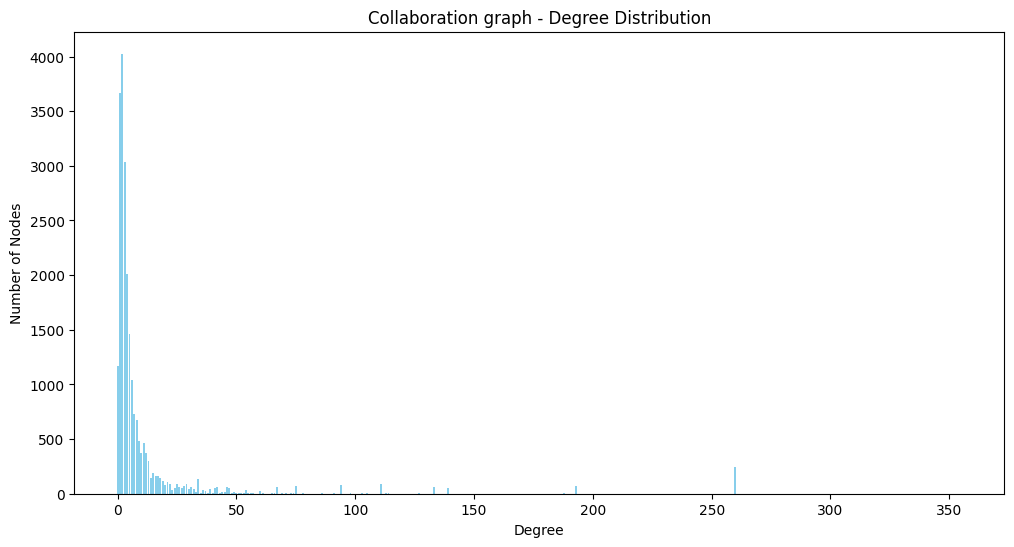

Please insert a number from 1 to 5 to select a feature, 0 to esc 2
You chose feature 2
Please insert the graph name to analize: 'collaboration Graph' or 'citation Graph', 0 to esc collaboration graph
Please insert a node name to analize David E. Goldberg
+-------------------+-----------------------------------------+--------------------------+-----------------------+------------------------+---------------------+
|     Node name     |               Graph name                |  Betweenness Centrality  |  PageRank Centrality  |  Closeness Centrality  |  Degree Centrality  |
+===================+=========================================+==========================+=======================+========================+=====================+
| David E. Goldberg | Graph with 23154 nodes and 139134 edges |       0.000745126        |      0.000205354      |       0.0798694        |     0.000496833     |
+-------------------+-----------------------------------------+--------------------------+-------

In [328]:
feature_input(collaboration_subgraph, citation_graph, subgraph, min_edges_to_remove, communities, dataset)

Please insert a number from 1 to 5 to select a feature, 0 to esc 3
You chose feature 3
Please insert a list of the author to visit Seth Gilbert, Kobbi Nissim
+--------+-------------------------------------------------------------------------------------------------------+
|  Step  |                                              Paper name                                               |
+========+=======================================================================================================+
|   0    |   Brewer's conjecture and the feasibility of consistent, available, partition-tolerant web services   |
+--------+-------------------------------------------------------------------------------------------------------+
|   1    |                            Consensus in the presence of partial synchrony                             |
+--------+-------------------------------------------------------------------------------------------------------+
|   2    |                           

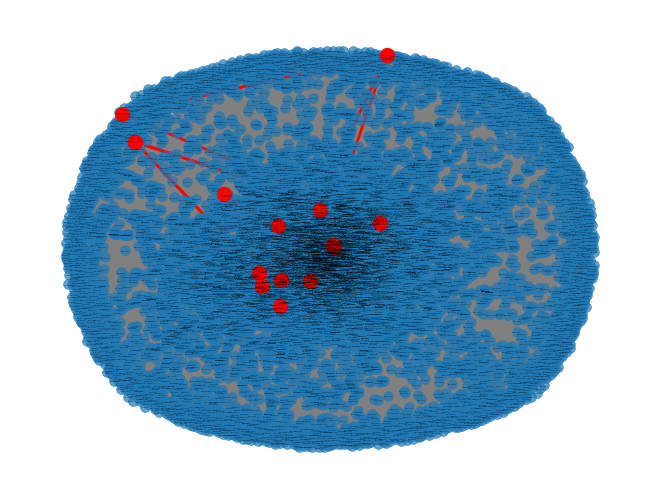

Please insert a number from 1 to 5 to select a feature, 0 to esc 0


In [365]:
feature_input(collaboration_subgraph, citation_graph, subgraph, min_edges_to_remove, communities, dataset)

Please insert a number from 1 to 5 to select a feature, 0 to esc 4
You chose feature 4
Please insert the first author node name to analize 2037227137
Please insert the first author node name to analize 2952186574
The minimum number of edges to disconnect the graph is: 3
{(2618530766, 2949650786), (2037227137, 2952186574), (2161381512, 2952186574)}




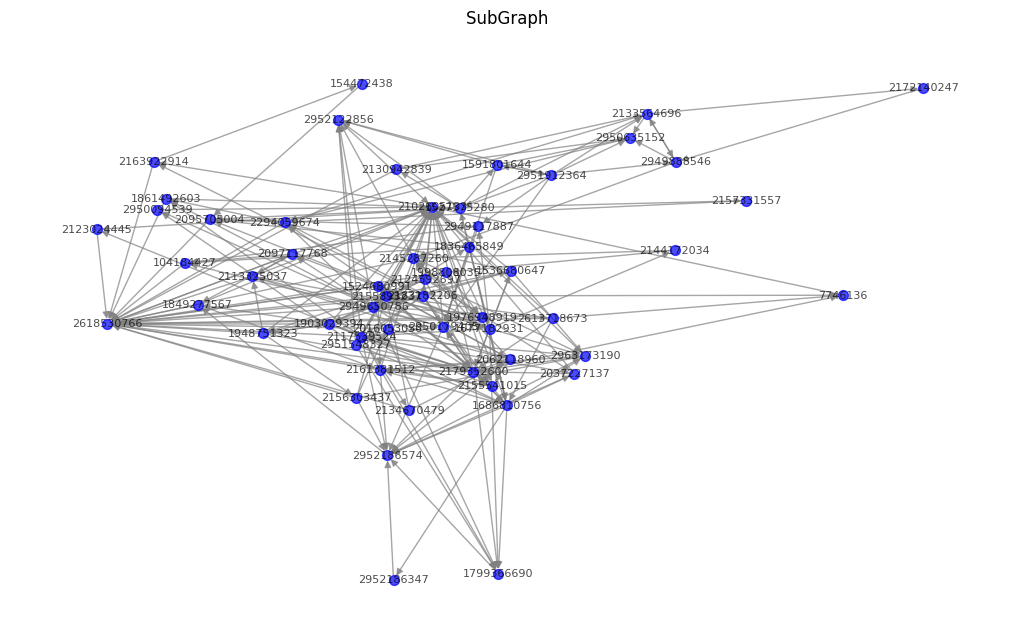

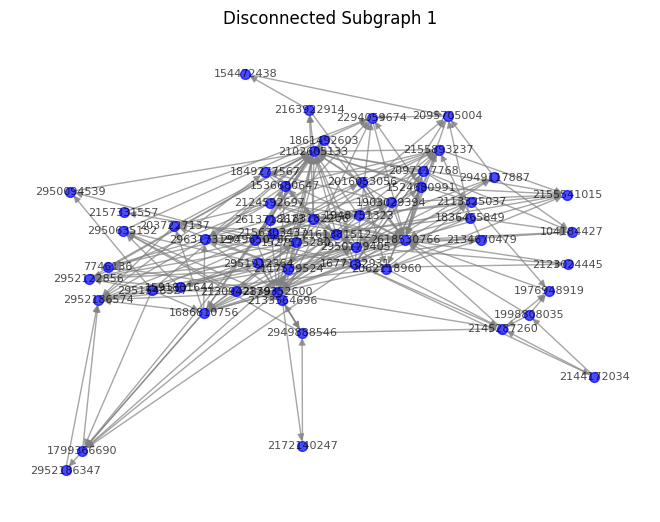

Please insert a number from 1 to 5 to select a feature, 0 to esc 0


In [366]:
feature_input(collaboration_subgraph, citation_graph, subgraph, min_edges_to_remove, communities, dataset)

Please insert a number from 1 to 5 to select a feature, 0 to esc 5
You chose feature 5 

Minimum number of edges to remove: 234

+--------------+-------------------------------------------------------------------------------------------------+
| Set number   | Elements                                                                                        |
+==============+=================================================================================================+
| Insieme 0    | 2037227137, 2144172034, 1686810756, 2161381512, 2134670479, 2613718673, 1903029394, 2155541015, |
|              | 2179352600, 2294059674, 1524680991, 1799366690, 2951548327, 2095705004, 2062118960, 1976948919, |
|              | 2124592697, 1836465849, 2949117887, 2016053056, 2117539524, 2963173190, 1536680647, 2097117768, |
|              | 2950094539, 2102605133, 2952186574, 2950179405, 2618530766, 2156303437, 1677182931, 7746136,    |
|              | 1948751323, 2145287260, 2163922914, 2949650786, 1

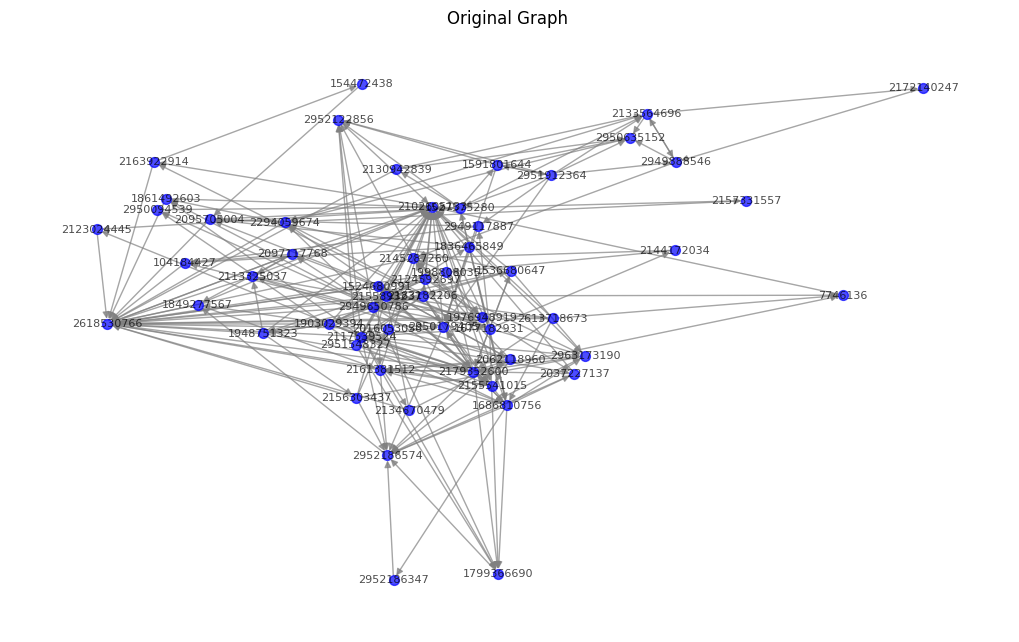

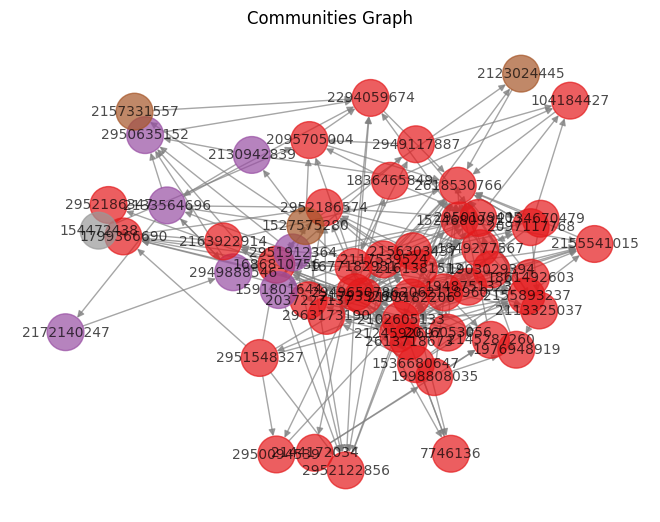

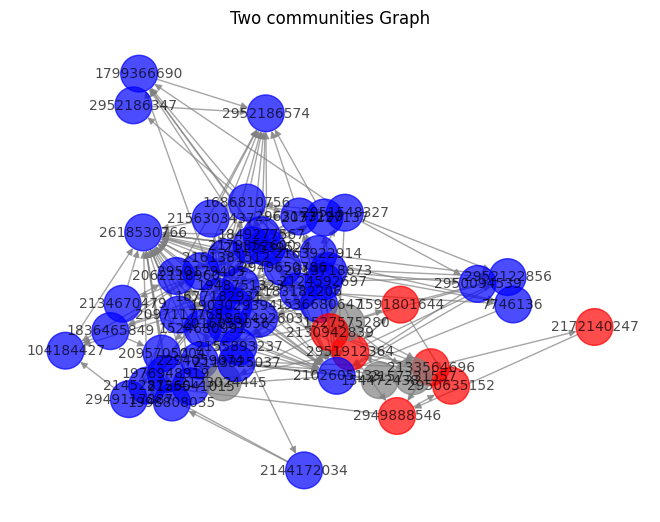

Please insert a number from 1 to 5 to select a feature, 0 to esc 0


In [367]:
feature_input(collaboration_subgraph, citation_graph, subgraph, min_edges_to_remove, communities, dataset)

## 4. Command Line Question (CLQ)

In this question, you should use any command line tools that you know to answer the following questions using the **directed** and **unweighted** graph that you have previously created: **Citation graph**:

1. Is there any node that acts as an important "connector" between the different parts of the graph?
2. How does the degree of citation vary among the graph nodes?
3. What is the average length of the shortest path among nodes?

---

For this task **we combined the use of the Python language and the AWK language**, which is (definition from the Wiki page) a data-driven scripting language consisting of a set of actions to be taken against streams of textual data.

We used both the language programms because, as we can read in detail below, to answer questions 1 and 3 we thought it best to use python anyway, which performed better for this type of task.

**The screenshot below shows the output of the file bash `CommandLine.sh`** and below the image there are few line of explation about the task performed and the results obtained. 

To learn more about the code and understand the implementation details it is available on GitHub.

We used the `citation_graph.csv` file that we saved previously.

![Screenshot of the outut obtained running the 'CommandLine' bash script](output_bash_script.png)

**1. Is there any node that acts as an important "connector" between the different parts of the graph?**

We're dealing with a citation graph, so connector nodes can be identified by their centrality measures that are metrics that help identify the most important or influential nodes within a graph. Exists various centrality measures but we choose the betweeneess centrality that measures the extent to which a node lies on paths between other nodes, so nodes with high betweenness centrality control the flow of information in the network since many shortest paths run through them, in few words they act as bridges between different parts of the network and it exactly what we have to do here.

So to perfom this task we used the `networkx` library that calculate the betweeness centrality and then retry the node that has the max betweenness centrality score and we found out that the **important connector node is the node 2147717514 that has a score of beteewneess centrality of 0.0037**, this score could be very small to be the largest one but it is due to the fact that the graph we're dealing with is a very large graph and it influnces the score of centrality. 

**2. How does the degree of citation vary among the graph nodes?**

To answer to this question we're focusing on the **in-degree** and the **out-degree** of each node and in particular we're focusing on the average of this two measures and we're finding out the **min** and the **max** to better understand how the degree vary amond the graph nodes.

First of all the **in-degree** represent the number of citation received from a paper (node on our graph) and the **out-degree**, instead, represent the number of citations made by that paper (node in our graph).
The results we have are the following: 
-**The average of in-degree is 6.47**, instead **the average of out-degree is 6.62**
- **The max of in-degree is 131**, instead **the max of out-degree is 152**
- **The min of bot in-degree and out-degree is 1**

These results shows that the citations made by a paper are greater that the citations received from a paper.


**3. What is the average length of the shortest path among nodes?**

We know from the theoretical lectures that an algorithm for finding the shortest path is the Dijskstra agorithm, but this is mainly used for weighted graphs, but we are using a graph which is indirect and unweighted, so we thought we would use the BFS algorithm to find the shortest path for each node and then take the average of these, however, we know from the analysis above that our graph is a very disconnected graph (in fact it has 9473 strongly connected components) This means that the graph is quite fragmented, so to avoid it we decided to examine each strongly connected component (SCC) individually and these are the results:

- **The average shortest path length across all SCCs (excluding single-node components) is approximately 1.158** and this is an average of the average path lengths calculated within each component.
- **The longest average path length within a single component is about 4.338** this represents the component with the most extended average distance between its nodes.
- **The shortest average path length within a component is 1.0** this likely represents small components with very direct connections between nodes.
- **There are 252 components with more than one node** meaning that path length calculations were applicable to these components.

This analysis finds out that most components appear to be tightly knit, as indicated by the relatively low average path lengths. However, the graph's overall structure is quite fragmented, with many small components, as reflected in the large number of single-node components that were excluded from this calculation.

---

## 5. Algorithmic Questions (AQ)

### Part A

A sports club hires you to create a team for the National Sports Championship. Every Italian Region sends its best $M$ athletes to compete in an intense 2-day sports event, and Rome is no exception!

The trainers of Team Rome need to carefully choose the best $M$ athletes from a pool of $N$ candidates. Each athlete is uniquely identified by a number from 1 to $N$ and possesses a set of $S$ sports skills. Each skill is represented by a 3-character string with only uppercase letters and a non-negative integer indicating the athlete's proficiency in that skill (always greater than 0).

The trainers have extensively studied the competition format and established an optimal set of (possibly repeated) skills the team should possess to ensure the best possible performance. Each of the ten selected athletes will be assigned one of these skills as their role within the team.

The team's overall score is the sum of the skill scores of its members in the roles they have been assigned. Other skills of each athlete do not contribute to the team's score.

Your task is to determine the maximum possible global score for Team Rome, given the list of candidates.

Note: Assigning an athlete to a role not listed in their skills is possible. In that case, that athlete's contribution to the global score will be 0.

**Input**: The input consists of $2+N(S+1)$ lines:

- Line 1: the numbers $N,M$ and $S$, separated by a space.
- Line 2: the optimal set of skills required by the trainers, as a list of $M$ space-separated skill names.
- Lines $3$, . . . ,$N(S+1)+2$: every group of $S+1$ lines is formatted as follows:
   - Line 1: the unique id of the athlete.
   - Lines $2$, . . . ,$S+1$: one skill name and the corresponding skilL score, separated by a space.

**Output**: Print the maximum global score that can be achieved with the available athletes.

### Your job:

1. Implement an algorithm to solve the described mentioned problem.

2. What is the **time complexity** (the Big O notation) of your solution? Please provide a detailed explanation of how you calculated the time complexity.

3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. If the two differ, which one is right? (why?)

4. If you algorithm has exponential time complexity, can you provide a **polynomial-time version**?

5. If $S=1$, how does the **time complexity** of an optimal algorithm to solve this problem change?

---

<div style="border: solid black; background-color: #ffffff; padding:10px;">

**Let's now answer to the question 1, so in the following cell there is the explanation of the algorithm and the algorithm itself to solve the problem.**

The aim of the mentioned problem is to assign skills to athletes in such a way as to maximize the total score.
The problems tells us that each athlete has a unique identifier and a set of skills with corresponding proficiency scores and an athlete might not have proficiency in the assigned skill, resulting in a score of 0 for that assignment, as written above the skills may be repeated in the requirement list, implying the same skill might need to be assigned to multiple athletes so how will we approch this problem?

First, we'll parse the input data to break down the number of athletes, the required skills and each athlete's proficiency in different skills, for the core problem we'll think the problem as a graph problem, where athletes are on one side, and skills are on the other, an edge between an athlete and a skill denotes the athlete's proficiency score in that skill. But now what we're intested in is to find the best way to "match" athletes to skills and it in in such a way similar to finding the maximum matching in a bipartite graph, but with the additional challenge of maximizing the sum of the weights (proficiency scores) of the edges selected. 

The approch we'll use is a **recursive approach** in order to try all possible assignments of skills to athletes so at each step, the algorithm will choose an athlete and a skill, and it will calculate the total score, but the important bit of this algorithm is also the usage of the memorization because using memorization we will store and reuse the scores of already-calculated states (combinations of assigned skills and athletes) to reduce the computational complexity in order to not calculate them again.
The recursive approach that we will use made us able to backtrack to explore other potential assignments after having explored an assignment.

**In conclusion the idea that we will use is to efficiently explore all possible assignments of athletes to skills while keeping track of the total score and optimizing for the highest possible total.**

In [1]:
def get_best_score(data, skill_index=0, assigned_athletes=None, memo=None):
    
    # splits the input data string into lines
    lines = data.strip().split('\n')
    
    # parses the first line to extract N, M, and S
    N, M, S = map(int, lines[0].split())
    
    # extracts the required skills from the second line of the data
    required_skills = lines[1].split()  
    
    # initializes a dictionary to store athletes' skills
    athlete_skills = {}
    
    # iterates over the lines to access each athlete's data that is in interval of S+1
    for i in range(2, len(lines), S + 1):
        # extracts the athlete's id
        athlete_id = int(lines[i])
        # initializes a sub-dictionary for this athlete
        athlete_skills[athlete_id] = {}
        # iterates over the skills for this athlete
        for j in range(1, S + 1):
            # parses the skill and its score, converts the score to an integer and assigns the score 
            # to the respective skill for this athlete
            skill, score = lines[i + j].split()
            score = int(score)
            athlete_skills[athlete_id][skill] = score
            
    # initializes the memoization dictionary if it hasn't been already
    if memo is None:
        memo = {}
        
    # initializes the set of assigned athletes if it hasn't been already
    if assigned_athletes is None:
        assigned_athletes = set()
        
    # base case for the recursion: checks if all skills have been assigned
    if skill_index == len(required_skills):
        return 0

    # creates a state tuple for memorization, consisting of the current skill index and the sorted tuple of assigned athletes
    state = (skill_index, tuple(sorted(assigned_athletes)))
    
    # returns the memoized score for this state
    if state in memo:
        return memo[state]
    
    # initializes the maximum score for this state and retrieves the current skill based on the skill_index
    max_score = 0
    skill = required_skills[skill_index]

    # iterates over each athlete and their skills and hecks if the athlete has not already been assigned a skill 
    # so retrieves the score for the current skill for this athlete, defaulting to 0 if the athlete doesn't have it 
    # and then adds the athlete to the set of assigned athletes
    for athlete_id, skills in athlete_skills.items():
        if athlete_id not in assigned_athletes:
            current_score = skills.get(skill, 0)
            assigned_athletes.add(athlete_id)

            # recursively step that calls the function to assign the next skill and adds the current score to the returned score
            score = current_score + get_best_score(data, skill_index + 1, assigned_athletes, memo)
            # updates the maximum score if the new score is higher
            max_score = max(max_score, score)

            # backtracks by removing the athlete from the set of assigned athletes
            assigned_athletes.remove(athlete_id)

    # memorizes and returns the maximum score for this state
    memo[state] = max_score
    return max_score

**Example of usage**

We now test our function on two different inputs proposed by the exercise and each of these inputs must give us outputs provided:

**INPUT 1**

<div style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">



14 10 1 # N, M, S  
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK #set of skills  
1  
BSK 98  
2  
ATH 14  
3  
HCK 82  
4  
HCK 9  
5  
FTB 90  
6  
ATH 52  
7  
HCK 95  
8  
TEN 85  
9  
RGB 46  
10  
SWM 16  
11  
VOL 32  
12  
SOC 41  
13  
SWM 59  
14  
SWM 34   

</div>


**OUTPUT 1**

<div style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">

370
</div>

In [2]:
input_data = """
14 10 1
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
1
BSK 98
2
ATH 14
3
HCK 82
4
HCK 9
5
FTB 90
6
ATH 52
7
HCK 95
8
TEN 85
9
RGB 46
10
SWM 16
11
VOL 32
12
SOC 41
13
SWM 59
14
SWM 34
"""

optimal_score = get_best_score(input_data)
print("Maximum global score achievable:", optimal_score)


Maximum global score achievable: 370


**INPUT 2**


<div style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">

14 10 2 # N, M, S  
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK #set of skills  
1  
BSK 98  
HCK 12  
2  
ATH 14  
VOL 1  
3  
HCK 82  
ATH 30  
4  
HCK 9  
SWM 27  
5  
FTB 90  
HCK 50  
6  
ATH 52  
RGB 80  
7  
HCK 95  
SWM 11  
8  
TEN 85  
RGB 7  
9  
RGB 46  
SWM 30  
10  
SWM 16  
BSK 12  
11  
VOL 32  
HCK 40  
12  
SOC 41  
FTB 12  
13  
SWM 59  
TEN 82  
14  
SWM 34  
VOL 20  
</div>

**OUTPUT 2**

<div style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
399
</div>

In [3]:
input_data= """
14 10 2  
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
1  
BSK 98  
HCK 12  
2  
ATH 14  
VOL 1  
3  
HCK 82  
ATH 30  
4  
HCK 9  
SWM 27  
5  
FTB 90  
HCK 50  
6  
ATH 52  
RGB 80  
7  
HCK 95  
SWM 11  
8  
TEN 85  
RGB 7  
9  
RGB 46  
SWM 30  
10  
SWM 16  
BSK 12  
11  
VOL 32  
HCK 40  
12  
SOC 41  
FTB 12  
13  
SWM 59  
TEN 82  
14  
SWM 34  
VOL 20  
"""

optimal_score = get_best_score(input_data)
print("Maximum global score achievable:", optimal_score)


Maximum global score achievable: 399


**As we can see both the proposed input achieve the output desired.**

---

<div style="border: solid black; background-color: #ffffff; padding:10px;">

**Let's now answer to the question 2: the time complexity of our algorithm, below the detailed explanation**

The time complexity is $O(N*C(N, M))$ where:
- $N$ is the number of athletes, 
- $M$ is the number of skills, 
- $C(N, M)$ is the the binomial coefficient of $N$ choose $M$

**Let's break it down carefully looking inside the function:**

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
lines = data.strip().split('\n')


<div style="border: solid black; background-color: #fffafa; padding:10px;">

Splitting the string: $O(2+N*(S+1))$, where $2+N*(S+1)$ is the length of the data string because contains the first two lines that are the $N,M,S$ values and the second line is the set of skills, after this 2 lines there will be each and every time the athlete id for a total of N lines followed by the number of lines equals to $S$ so in the end after the first 2 lines we will have $N*(S+1)$ lines

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
N, M, S = map(int, lines[0].split()) 

<div style="border: solid black; background-color: #fffafa; padding:10px;">
    
Parsing the first line to integers: $O(1)$

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
required_skills = lines[1].split()

<div style="border: solid black; background-color: #fffafa; padding:10px;">
    
Splitting the required skills: $O(M)$, where $M$ is the number of skills and the lines that cointains the skill contains exactly $M$ values

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
athlete_skills = {}

<div style="border: solid black; background-color: #fffafa; padding:10px;">

Initializing the dictionary: $O(1)$

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
for i in range(2, len(lines), S + 1):  
    athlete_id = int(lines[i])    
    athlete_skills[athlete_id] = {}  
    for j in range(1, S + 1):  
        skill, score = lines[i + j].split()  
        score = int(score)  
        athlete_skills[athlete_id][skill] = score 
</pre>



<div style="border: solid black; background-color: #fffafa; padding:10px;">

Each step in the *for* loops are $O(1)$ because is time fixed operation  
The outer *for* loop: $O(S)$  
The inner *for* loop: $O(S)$ where S is the number of skills per athlete  
**The overall *for* loop: $O(N*S)$**   

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
if memo is None:  
    memo = {}  
if assigned_athletes is None:  
    assigned_athletes = set()

<div style="border: solid black; background-color: #fffafa; padding:10px;">

These are checks and initializations so they have $O(1)$ time complexity

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
if skill_index == len(required_skills):  
    return 0  

<div style="border: solid black; background-color: #fffafa; padding:10px;">
    
This step is checking if all skills are assigned so the time complexity is fixed $O(1)$

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
state = (skill_index, tuple(sorted(assigned_athletes)))  
if state in memo:  
    return memo[state]  

<div style="border: solid black; background-color: #fffafa; padding:10px;">

The first line here create the state tuple and the time complexity is $O(M*log(M))$ (sort step is $O(M*log(M))$, tuple creation is $O(M)$)  
The step that checks if the state is in the memo takes $O(1)$ in average, but could be worse up to $O(M)$

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
max_score = 0  
skill = required_skills[skill_index]


<div style="border: solid black; background-color: #fffafa; padding:10px;">

Initializing max_score and retrieving a skill is of the order of $O(1)$

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
for athlete_id, skills in athlete_skills.items():  
    if athlete_id not in assigned_athletes:  
        current_score = skills.get(skill, 0)  
        assigned_athletes.add(athlete_id)  
        score = current_score + recursive_with_memoization(data, skill_index + 1, assigned_athletes, memo)  
        max_score = max(max_score, score)  
        assigned_athletes.remove(athlete_id)  

<div style="border: solid black; background-color: #fffafa; padding:10px;">


The for loop iterates over N athletes, the the checks and updates are $O(1)$ each. The core of the time complexity is the recursive call that took $O(N*C(N, M))$ because for each skill, the algorithm iterates over all athletes to find the best match and in the worst case, this results in $N$ choices for the first skill, $N-1$ for the second, and so on, until $M$ skills are assigned. However, since the order of assignment doesn't matter because only the mx score interested to us, the actual number of states to consider is bound by the combination of choosing M athletes out of N, which is "$N$ choose $M$" $(C(N,M))$

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
memo[state] = max_score  
return max_score


<div style="border: solid black; background-color: #fffafa; padding:10px;">

The memorizing part have a $O(1)$ time complexity in average but $O(M)$ in the worst case, instead the returning step has $O(1)$ time complexity

<div style="border: none; background-color: #fffafa; padding:10px;">
    
In the end we said that the time complexity is $O(N*C(N, M))$ but the binomial coefficient can be approximated as $O(N^M)$ in the worst case (when M is small compared to N). Therefore, the worst-case time complexity can be approximated as $O(N^{M+1})$, what we can say looking at this time complexity is that the algorithm may become quite inefficient for large values of $N$ and $M$, especially when $M$ is not significantly smaller than $N$

---

<div style="border: solid black; background-color: #ffffff; padding:10px;">

**Let's now answer to the question 3: ask ChatGPT or any other LLM chatbot tool to check my code's time complexity (the Big O notation), compare the answers and explain which one is right and why if the two answers are different**

I asked **ChatGPT** about the time complexity of my algorithm and he told me that the time complexity is $O(N*M*2^N)$ and not ad we said $O(N*C(N, M))$ but in our opinion the two answers are correlated because if we thought about the ChatGPT answer we could say that he analyzed the complexity of the algorithm in another manner that is focused maybe on considering the worst-case scenario because we have:

$N$ choices per skill: for each skill we have up to $N$ athletes to choose from and this contributes a factor of $N$ to the complexity.

Depth of Recursion ($M$): the recursion part goes as deep as the number of skills, $M$ because for each skill we're making a new set of choices so this contributes a factor of $M$ to the complexity.

All combinations of athletes ($2^N$): the most significant factor in the **ChatGPT analysis** is considering all possible combinations of athletes that are $2^N$ possible subsets of athletes (including the empty set and the set of all athletes). This is because, for each athlete, there are two choices: either they are included in a particular subset or they are not.

Our algorithm essentially performs an exhaustive search over all possible combinations of athlete assignments to skills and for each skill we are considering whether to include each athlete in the assignment or not leading to the $2^N$ factor. The interaction of multiple skills ($M$) and the need to explore choices for each of these skills with all possible combinations of athletes leads to the multiplication of these factors.

**So in conclusion we thought that neither answers are wrong because the ChatGPT suggested time complexity is a more generic and pessimistic estimate that does not take memorization into account and assumes that the algorithm must explore every possible subset of athletes for each skill, regardless of assignment order or previous stored calculations emphasizing the exhaustive nature of the search over all possible combinations of athletes for each skill and the $O(N * C(N, M))$ time complexity is a more accurate estimate for the complexity of our algorithm because it takes into account unique combinations rather than all possible subsets.**

---

<div style="border: solid black; background-color: #ffffff; padding:10px;">

**Let's now answer to the question 4: our algorithm has exponential time complexity so we try to generate a polynomial-time version of our algorithm**

We thought for a long time whether our algorithm **could be modified** in such a way as to have **polynomail time complexity** but the answer is that we **cannot achieve** such a great result with a naive algorithm because when dealing with the problem of selecting athletes with multiple skills, so when we have $S>1$, creating a polynomial time algorithm can be challenging for several reasons for example we we should deal with:

- **Complexity of the problem**: in particular the combinatorial nature of the problem because its core is combinatorial due to the fact that each athlete can have multiple skills, the number of possible combinations of athletes to cover all required skills grows exponentially with the number of athletes and skills and we thought that this combinatorial explosion makes it difficult to find an optimal solution within polynomial time.

- **Variability of skills and scores**: Each athlete can have a different set of skills with varying scores and this variability increases the complexity of making optimal choices because with multiple skills per athlete, the decision of which athlete to choose for which skill becomes complex.

We thought if we could use a greedy algorithm but greedy algorithms, which make the locally optimal choice at each step, often fail in this scenario because the best choice at a given moment might not lead to an overall best solution. Furthermore athletes can share skills, leading to overlapping options for each required skill and this overlap complicates the process of ensuring that each skill is covered by a unique athlete while also trying to maximize the total score.

---

<div style="border: solid black; background-color: #ffffff; padding:10px;">

**Let's now answer to the question 5: we consider $S=1$ and let's have a look how the time complexity of an optimal algorithm to solve this problem changes**

If we think about the case of $S=1$ the problem and then, of course our algorithm, which involves recursive exploration with memoization, can be simplified and optimized because now:

- **Each athlete has only one skill:** this eliminates the need for a nested dictionary to store multiple skills per athlete and instead of it we can use a simpler structure where each athlete is directly associated with their single skill and its score.
Reduced Recursive Complexity:

- **The recursive exploration isn't necessary** because for each athlete we only need to consider one skill.

- **We can use different type of data structure and more simple code to deal with** since each athlete only has one skill the state can be represented by the set of athletes that have been considered and the number of skills already assigned.

- **The time complexity improves** 

So we can revise our algorithm since each athlete has exactly one skill we can sort the athletes based on their proficiency in each skill and then select the top athlete for each required skill (assuming that the best team composition would include the highest-scoring athlete for each required skill), so we can revise our algorithm creating a mapping of skills to each athletes along with their scores, then we can sort by proficiency for each skill and the we select the athletes with the highest score who has not already been selected and if no athletes have a particular skill, that role contributes a score of 0. At the end we sum the scores of the selected athletes to get the total team score.

In [4]:
def max_global_score_optimized(data):
    # splitting the input data into lines
    lines = data.strip().split('\n')

    # extracting N, M, S from the first line
    N, M, S = map(int, lines[0].split())

    # extracting the required skills from the second line
    required_skills = lines[1].split()

    # list of athletes with their skill and score
    athletes = []
    for i in range(2, len(lines), S + 1):
        athlete_id = int(lines[i])
        skill, score = lines[i + 1].split()
        score = int(score)
        athletes.append((score, skill, athlete_id))

    # sorting athletes by score in descending order
    athletes.sort(reverse=True)

    # selecting athletes for each required skill
    skill_assigned = set()
    total_score = 0
    for skill in required_skills:
        for score, athlete_skill, athlete_id in athletes:
            if athlete_skill == skill and athlete_id not in skill_assigned:
                total_score += score
                skill_assigned.add(athlete_id)
                break

    return total_score

**Example of usage**

We now test our function on an input proposed by the exercise:

In [5]:
input_data = """
14 10 1
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
1
BSK 98
2
ATH 14
3
HCK 82
4
HCK 9
5
FTB 90
6
ATH 52
7
HCK 95
8
TEN 85
9
RGB 46
10
SWM 16
11
VOL 32
12
SOC 41
13
SWM 59
14
SWM 34
"""

optimal_score= max_global_score_optimized(input_data)
print("Maximum global score achievable:", optimal_score)

Maximum global score achievable: 370


**Let's now analyze how changes the time complexity**

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
lines = data.strip().split('\n')
N, M, S = map(int, lines[0].split())
required_skills = lines[1].split()

<div style="border: solid black; background-color: #fffafa; padding:10px;">

**Parsing the input**: it involves splitting the data into lines that requires $O(2+N*(S+1))=O(2+2*N)$, extracting N, M, S that requires $O(1)$ as it's a simple operation and then extracting required skills that have $O(M)$ time complexity since there are $M$ skills.

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
athletes = []
for i in range(2, len(lines), S + 1):
   athlete_id = int(lines[i])
   skill, score = lines[i + 1].split()
   score = int(score)
   athletes.append((score, skill, athlete_id))

<div style="border: solid black; background-color: #fffafa; padding:10px;">

**Creating athletes list:** the loop runs $\frac{N}{(S+1)}=\frac{N}{2}$ times, as each athlete's data is spread over $S+1=2$ lines, LOOKING Inside the loop we have kind of ooperations are that has $O(1)$ time complexity, so this part is $O(N)$.

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
athletes.sort(reverse=True)

<div style="border: solid black; background-color: #fffafa; padding:10px;">

**Sorting athletes:** the sorting part as we know takes $O(N*log(N))$ since there are $N$ athletes

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">

skill_assigned = set()
total_score = 0
for skill in required_skills:
    for score, athlete_skill, athlete_id in athletes:
        if athlete_skill == skill and athlete_id not in skill_assigned:
            total_score += score
            skill_assigned.add(athlete_id)
            break

<div style="border: solid black; background-color: #fffafa; padding:10px;">

**Selecting athletes:** the outer loop runs $M$ times for each required skill and the inner one potentially runs up to $N$ times for each athlete, but in the worst case, this part is $O(M*N)$

<div style="border: none; background-color: #fffafa; padding:10px;">
    
So in the end for the calculation of the time complexity parsing input give a contribution of $O(2+2*N+M)$, the creation of the athletes list gives $O(N)$, the sorting part gives $O(N*log(N))$ and the selection gives a contribution of $O(M*N)$, so in the end the dominant term here is either $O(N*log(N))$ or $O(M*N)$, depending on the relationship between $M$ and $N$ because if we think about it if $M$ is much smaller than $N$, then $O(N*log(N))$ dominates, but if $M$ and $N$ pretty close, then $O(M*N)$ could be the dominating term. **In conclusion, the overall time complexity of this algorithm is $\mathbf{O(N*log(N)+M*N)}$, which simplifies to $\mathbf{O(M*N)}$ if, as we said above, $M$ and $N$ are of the same order.**

---

### Part B

The success of a project depends not only on the expertise of the people involved but also on how effectively they work together as a team. So this time, instead of focusing on who has the best skills, let's focus on finding a group of individuals who can function as a team to accomplish a specific task.

Given a set of skills $T$, our goal is to find a set of individuals $X'\subseteq X$, such that every required skill in $T$ is exhibited by at least one individual in $X'$. Additionally, the members of team $X'$ should have low effort to work together i.e. all the members of the team $X'$ work well with each other.

This problem can be easily visualised with graphs: we define an undirected weighted graph $G=(V,E)$ where every element $x_i \in X$ has a corresponding node $v_i \in V$. The weights of the edges represent the effort required to work well together: the lower the weight of an edge between two nodes, the less effort the corresponding team members need to work well together.

We define as acceptable solution any subset $V' \subseteq V$ such that $T \cap \cup_{v_i \in V'} S_{v_i}$ where $S_{v_i} =$ {set of skills of member $x_i$ corresponding to the vertex $v_i$}. The goal is to find, among all acceptable solutions, the one that minimizes the effort to work together $E_c(V')$. The effort to work together $E_c(V')$ is the cost of the minimum spanning tree on the subgraph $G[V']$ i.e. the sum of the weights of its edges.

### Your job:

1. Prove or disprove that the problem is NP-complete.
2. Write a heuristic in order to approximate the best solution for this problem.
3. What is the time complexity of your solution?

---

<div style="border: solid black; background-color: #ffffff; padding:10px;">

**Let's now answer to the question 1: proof of the NP-completeness of the problem.**


We want to analyze whether the problem described is **NP-complete.**

First of all we're dealing with an optimization problem and to explore the **NP-completeness** we'll consider its decision problem version to prove NP-completeness.

We can state the decision problem in this way:

given **a set of skills $T$, a set of individuals $X$, each with a subset of skills and represented as nodes in an undirected weighted graph $G = (V, E)$ (the weights represent the effort required to work together), a threshold effort level $k$**, what the problem is asking if is there **a subset of individuals $X' \subseteq X$ such that every skill in $T$ is covered by at least one individual in $X'$ and the total effort to work together $E_c(V')$ for the team $X'$ (as defined by the minimum spanning tree of the subgraph induced by $X'$) is less than or equal to $k$**.

First of all recap when a problem is in **NP** and a problem is in **NP if a solution to the problem can be verified in polynomial time.** In our context we can prove the **NP-completeness** proving that the problem is **both in NP and NP-hard**.

Looking at our problem given a subset $X'$ we can verify whether every skill in $T$ is covered and whether the total effort $E_c(V')$ is less than or equal to $k$ in polynomial time, now to prove **NP-hardness**, we reduce a known **NP-complete problem to our problem** and if we think about the example we saw in class **the set cover problem**, which we know to be NP-complete, is a potential candidate for reduction, indeed:

Let each individual in $X$ represent a set, where the set contains the skills of that individual and let the universe of elements in the set cover problem be the set of skills $T$.

This demonstrates that finding a subset of individuals such that every skill in $T$ is covered is at least as hard as solving the set cover problem.

In conclusion since the problem is **both in NP and NP-hard** we can conclude that the decision problem version is **NP-complete**, but remember that we're dealing with an **optimization problem** as original problem so now we have proved that that problem is **NP-complete** due to the fact that the decision version is.

<div style="border: solid black; background-color: #ffffff; padding:10px;">

**Let's now answer to the question 2: our heuristic in order to approximate the best solution for this problem.**

We thought about a **greedy algorithm** to solve this problem because this is a heuristic approach (method particularly useful for NP-hard problems, as they provide approximate solutions in a reasonable amount of time).   


The goal of the problem is to form a team that covers all required skills with the minimum effort for collaboration so we can think about **this problem as a variant of the minimum spanning tree (MST) problem with an additional constraint on covering all required skills**, so the idea for an algorithm that we have is the following: 

**- Start with an empty team and iteratively add individuals to the team.**
**- In each step choose the individual who adds the most uncovered skills at the least additional effort.**
**- Stop when all required skills are covered.**

So in terms of algorithm steps we can follow three steps **"INITIALIZATION", "ITERATIONS", "BUILDING MINIMUM SPANNING TREE", "RETURN SOLUTION"** and in partiucular this is the pseudocode of our algorithm:

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
def team_formation(G, T):  
  Q = initialize_priority_queue(G, T)  
  X_prime = set()  
  covered_skills = set()  
  while covered_skills != T:  
    best_candidate = Q.pop()  
    X_prime.add(best_candidate)  
    covered_skills.update(skills_of(best_candidate))  
    update_priority_queue(Q, X_prime, T, covered_skills)  
  effort = compute_minimum_spanning_tree_effort(G, X_prime)  
  return X_prime, effort
<pre>


Let's have a deep look on it:

- Set $T$ as the set of required skills.
- Create a priority queue $Q$ that orders individuals based on the ratio of the number of new skills they can add to the team to the additional effort they bring.
- Initialize the team $X'$ as an empty set.
- While there are skills in $T$ not yet covered by $X'$ the algorithm will select and remove the individual from $Q$ who has the highest ratio of new skills to additional effort, it will add this individual to $X'$, then it will update $T$ by removing the skills now covered by the new team member and at the end of the while loop the algorithm will update the priority queue $Q$ in order to reflect the new situation (since the addition of a new team member can change the ratio for the remaining candidates).
- Build minimum spanning tree: once all skills are covered the algorithm will construct the subgraph induced by $X'$ and it will compute the minimum spanning tree of this subgraph to determine the total effort $E_c(V')$ - this step can be covered with **Prim's algorithm for example**.
- The last step is the returning solution: the resulting team $X'$ and the effort $E_c(V')$ that form the approximate solution.

#### Clarifications

Functions like `initialize_priority_queue`, `update_priority_queue`, `skills_of` and `compute_minimum_spanning_tree_effort` called in our pseudocode are name at ramndom choosen to deal with the problem and break down the algorithm, they have to be defined and their aim is what we have previously discuss.

<div style="border: solid black; background-color: #ffffff; padding:10px;">

**Let's now answer to the question 3: analysis of time complexity of our solution**

To better analyze the time complexity of the `team_formation` function we consider the complexity of each operation within the loop and let's assume:

- $n$: number of individuals (nodes in the graph $G$).
- $m$: number of edges in the graph $G$.
- $s$: number of skills in the set $T$.

Let's break down each step in the function.

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
Q = initialize_priority_queue(G, T)

<div style="border: solid black; background-color: #fffafa; padding:10px;">

The complexity depends on the implementation of the priority queue and the computation of initial ratios and it would be $O(n \cdot f(s))$, where $f(s)$ is the complexity of calculating the ratio for each individual

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
X_prime = set()
covered_skills = set()

<div style="border: solid black; background-color: #fffafa; padding:10px;">

These initalization counts $O(1)$ for the time complexity because are fixed operation

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
while covered_skills != T:
    best_candidate = Q.pop()
    X_prime.add(best_candidate)
    covered_skills.update(skills_of(best_candidate))
    update_priority_queue(Q, X_prime, T, covered_skills)

<div style="border: solid black; background-color: #fffafa; padding:10px;">

In total this while loop runs until all skills are covered, potentially $n$ times in the worst case because removing the top element from a priority queue is typically an $O(\log n)$ operation, adding an individual to `X_prime` and updating `covered_skills` can be done in $O(s)$. Updating the queue requires $O(n \cdot f(s))$ for each update.

<pre style="border: none; background-color: #f0f8ff; padding:10px; font-family: 'Roboto Mono', monospace;">
effort = compute_minimum_spanning_tree_effort(G, X_prime)

<div style="border: solid black; background-color: #fffafa; padding:10px;">

This is the core of the algorithm and the computation of the minimum spanning tree can be done using algorithms like Prim's and so typically with complexity $O(m \cdot \log n)$ or $O(n \cdot \log n)$.

<div style="border: none; background-color: #fffafa; padding:10px;">

So in the end combining these time complexity, the complexity is:

$O(n \cdot f(s)) + O(n) \times (O(\log n) + O(s) + O(n \cdot f(s))) + O(m \cdot \log n)$

Simplifying and assuming $f(s)$ is not large compared to $n$ and $m$ and considering $m$ could be as large as $O(n^2)$ in a dense graph the dominating term could be $O(n^2 \cdot f(s)) + O(m \cdot \log n)$.

This is an estimation due to the fact that each time complexity can vary based on how the operation described will be implemented. 
